In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from rich.console import Console
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

sys.path.append(os.path.dirname(os.getcwd()))
from tools.utils import (
    StructureEncoding,
    Target,
)
from tools.data_loader import TestSet, TestSplit, data_loader
from tools.transform import CustomLogTargetTransformer
from tools.train import evaluate_models
%load_ext autoreload
%load_ext rich
%autoreload 2

In [2]:
console = Console()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading Data

In [4]:
DATA_DIR = os.path.join(
    os.path.dirname(os.path.dirname(os.getcwd())), "data/"
)
DATA_PATH = os.path.join(DATA_DIR, "data.csv")

In [5]:
encoding = StructureEncoding.ATOMIC
target = Target.DELTA_E
test_sets_cfg = [
    TestSet("Parameter gen.", size=0.1, split=TestSplit.ROW),
    TestSet("Structure gen.", size=0.1, split=TestSplit.STRUCTURE),
]

# Data Loading
X_train_raw, y_train_raw, test_sets_raw = data_loader(
    target=target,
    encoding=encoding,
    data_path=DATA_PATH,
    test_sets_cfg=test_sets_cfg,
    console=console,
    remove_ref_rows=True,
)

⠧ Loading data

╭───────── Loaded Dataset ─────────╮
│ Train set: 80%                   │
│ Test set 0 (Parameter gen.): 10% │
│ Test set 1 (Structure gen.): 10% │
│ Total datapoints: 539583         │
│ Size: ~388.5MB                   │
╰──────────────────────────────────╯

In [6]:
std_scaler = StandardScaler().fit(X_train_raw)
target_transformer = CustomLogTargetTransformer().fit(y_train_raw)

In [7]:
X_train = torch.Tensor(std_scaler.transform(X_train_raw)).to(device)
y_train = torch.Tensor(y_train_raw.values).reshape(-1, 1).to(device)
logy_train = torch.Tensor(target_transformer.transform(y_train_raw).values).reshape(-1,1).to(device)

test_sets = []
test_sets_log = []
for name, X_test_raw, y_test_raw in test_sets_raw:
    X_test = torch.Tensor(std_scaler.transform(X_test_raw)).to(device)
    y_test = torch.Tensor(y_test_raw.values).reshape(-1, 1).to(device)
    logy_test = torch.Tensor(target_transformer.transform(y_test_raw).values).reshape(-1, 1).to(device)
    test_sets.append((name, X_test, y_test))
    test_sets_log.append((name, X_test, logy_test))

# Model definition

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        N = 100
        self.layers = nn.Sequential(
            nn.Linear(input_size, N),
            nn.ReLU(),
            nn.Linear(N, N),
            nn.ReLU(),
            nn.Linear(N, N),
            nn.ReLU(),
            nn.Linear(N, 1),
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def predict(self, x):
        return self.forward(x).detach()

In [35]:
model = MLP(X_train.shape[1])
model = model.to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=89, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [36]:
class MAPELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MAPELoss, self).__init__()
 
    def forward(self, output, target):
        return torch.mean((target - output).abs() / target.abs())

In [42]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_fn = nn.MSELoss()
loss_test = nn.MSELoss()

epochs = 500

for epoch in range(epochs):
    # train phase
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, logy_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # eval phase
    model.eval()
    print(
        f"[Epoch {epoch+1}/{epochs}]: train {loss_test(model(X_train), logy_train):.4e}"
        +"\ttests "
        + "\t".join([f"{name}: {loss_test(model(X_test), y_test):.4E}" for name, X_test, y_test in test_sets_log]),
        end="\r"
    )

In [43]:
evaluate_models(
    {"MLP": deepcopy(model).to("cpu")},
    X_train.cpu(),
    logy_train.cpu(),
    [(name, X_test.cpu(), y_test.cpu()) for name, X_test, y_test in test_sets_log],
    console,
)

Output()

                                    MLP                                     
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Loss name  ┃   Train    ┃ Test - Parameter gen. ┃ Test - Structure gen. ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│     MSE     │ 6.5158E-01 │      6.6391E-01       │      3.8141E+00       │
│     MAE     │ 5.1402E-01 │      5.2184E-01       │      1.4867E+00       │
│    MAPE     │ 6.1695E-02 │      6.2646E-02       │      1.9927E-01       │
│ Custom MAPE │ 1.9762E-02 │      2.2036E-02       │      7.7153E+01       │
│   50%-APE   │ 4.3470E-02 │      4.4182E-02       │      1.4324E-01       │
│   90%-APE   │ 1.3479E-01 │      1.3735E-01       │      4.3486E-01       │
└─────────────┴────────────┴───────────────────────┴───────────────────────┘

Text(0.5, 0, 'ecutwfc')

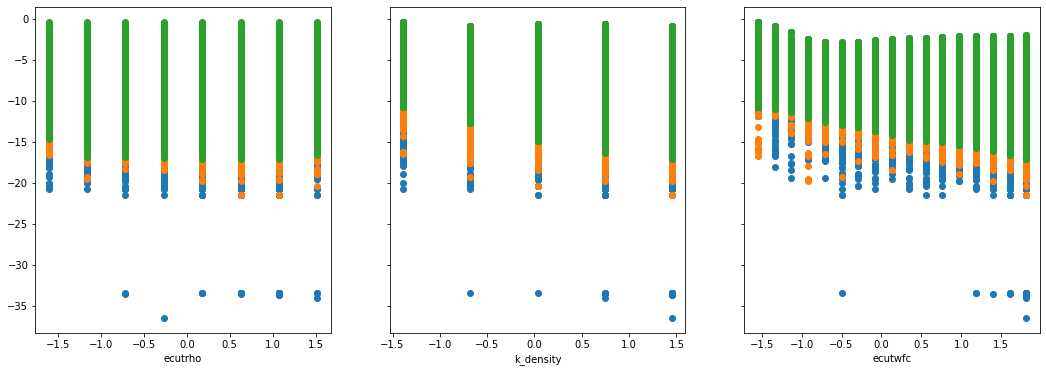

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3,figsize=(18,6), sharey=True)
for i in range(3):
    ax[i].scatter(X_train.cpu().numpy()[:,i], logy_train.cpu())
    ax[i].scatter(X_test.cpu().numpy()[:,i], logy_test.cpu())
    ax[i].scatter(X_test.cpu().numpy()[:,i], model(X_test).cpu().detach())
ax[0].set_xlabel("ecutrho")
ax[1].set_xlabel('k_density')
ax[2].set_xlabel('ecutwfc')